In [29]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as stats

In [31]:
# set parameters
σ = 5      # σ > 1
τ = 0.1    # τ > 0
da = 0.1   # 0 < da < 1
db = 0.1   # 0 < db < 1
κ = 1      # κ > 0
pr = 0.5   # pr > 0
cbar = 0   # optional

# income/endowment
ma = 10
mb = 10
mc = 10

# supply thresholds
# 'shortage' defined if drops below this
thresha = 15.80/2
threshb = 15.80/2
threshc = 14.91/2
threshtot = 46.50/2

# tariffs and subsidies
tfa = 0
tfb = 0
tfc = 0
tia = 0
tib = 0
sfa = 0
sfb = 0
sia = 0
sib = 0
ea = 0    # 0 <= ea < 1
eb = 0    # 0 <= eb < 1

In [39]:
# input producers form expectations, decide whether to enter

# input producer entry process
na = 1 # initialise number of firms at 1
nb = 1

while True:

    # prices
    pia = σ/(σ - 1)*(cbar - sia + pr/(1 - da))
    pib = σ/(σ - 1)*(cbar - sib + pr/(1 - db))
    
    if na > 0 and nb > 0:
        pfa = (pia**(1 - σ) + (pib*(1 + tia)*(1 + τ))**(1 - σ))**(1/(1 - σ))
        pfb = ((pia*(1 + tib)*(1 + τ))**(1 - σ) + pib**(1 - σ))**(1/(1 - σ))
        iaa_share = pia**(1 - σ)/(pia**(1 - σ) + (pib*(1 + tia)*(1 + τ))**(1 - σ))
        iab_share = (pia*(1 + tib)*(1 + τ))**(1 - σ)/((pia*(1 + tib)*(1 + τ))**(1 - σ) + pib**(1 - σ))
        iba_share = (pib*(1 + tia)*(1 + τ))**(1 - σ)/(pia**(1 - σ) + (pib*(1 + tia)*(1 + τ))**(1 - σ))
        ibb_share = pib**(1 - σ)/((pia*(1 + tib)*(1 + τ))**(1 - σ) + pib**(1 - σ))
    elif na > 0 and nb == 0:
        pfa = pia
        pfb = pia*(1 + tib)*(1 + τ)
        iaa_share = 1
        iab_share = 1
        iba_share = 0
        ibb_share = 0
    elif na == 0 and nb > 0:
        pfa = pib*(1 + tia)*(1 + τ)
        pfb = pib 
        iaa_share = 0
        iab_share = 0
        iba_share = 1
        ibb_share = 1
    else:
        print("Error: No entry.")
    
    # quantities
    ## final good quantities
    xfaa = pfa**(-σ)*ma/(pfa**(1 - σ) + (pfb*(1 + tfa)*(1 + τ))**(1 - σ))
    xfba = (pfb*(1 + tfa)*(1 + τ))**(-σ)*ma/(pfa**(1 - σ) + (pfb*(1 + tfa)*(1 + τ))**(1 - σ))
    xfab = (pfa*(1 + tfb)*(1 + τ))**(-σ)*mb/((pfa*(1 + tfb)*(1 + τ))**(1 - σ) + pfb**(1 - σ))
    xfbb = pfb**(-σ)*mb/((pfa*(1 + tfb)*(1 + τ))**(1 - σ) + pfb**(1 - σ))
    xfac = ((pfa*(1 + tfc)*(1 + τ))**(-σ)*mc/
            ((pfa*(1 + tfc)*(1 + τ))**(1 - σ) + (pfb*(1 + tfc)*(1 + τ))**(1 - σ)))
    xfbc = ((pfb*(1 + tfc)*(1 + τ))**(-σ)*mc/
            ((pfa*(1 + tfc)*(1 + τ))**(1 - σ) + (pfb*(1 + tfc)*(1 + τ))**(1 - σ)))
    
    ## input quantities
    xfa_revenue = pfa*(xfaa + xfab + xfac)
    xfb_revenue = pfb*(xfba + xfbb + xfbc)
    
    xiaa = (xfa_revenue*iaa_share)/pia
    xiab = (xfb_revenue*iab_share)/(pia*(1 + tib)*(1 + τ))
    xiba = (xfa_revenue*iba_share)/(pib*(1 + tia)*(1 + τ))
    xibb = (xfb_revenue*ibb_share)/pib
    xia = xiaa + xiab
    xib = xiba + xibb
    
    # find quantity of raw materials to meet expected demand
    if na > 0:
        ra = xia/((1 - da)*na)
    else: ra = 0

    if nb > 0:
        rb = xib/((1 - db)*nb)
    else: rb = 0
    
    # calculate expected profits at that quantity
    epa = pia*ra*(1 - da) + sia*ra*(1 - da) - cbar*ra*(1 - da) - pr*ra - κ*(1 - ea)
    epb = pib*rb*(1 - db) + sib*rb*(1 - db) - cbar*rb*(1 - db) - pr*rb - κ*(1 - eb)

    # if positive expected profits, more firms enter
    if epa > 0:
        na = na + 1
    if epb > 0:
        nb = nb + 1

    # if negative profits, subtract one firm and stop
    if epa < 0 and epb < 0:
        na = na - 1
        nb = nb - 1

        # if no firms enter, set number to zero
        if na < 0: 
            na = 0
        if nb < 0: 
            nb = 0
            
        break

# raw materials sourced and expected profits

if na > 0:
    ra = xia/((1 - da)*na)
else:
    ra = 0

if nb > 0:
    rb = xib/((1 - db)*nb)
else: rb = 0

epa = pia*ra*(1 - da) + sia*ra*(1 - da) - cbar*ra*(1 - da) - pr*ra - κ*(1 - ea)
epb = pib*rb*(1 - db) + sib*rb*(1 - db) - cbar*rb*(1 - db) - pr*rb - κ*(1 - eb)

# update expected prices and quantities to reflect entry decisions

if na > 0 and nb > 0:
    pfa = (pia**(1 - σ) + (pib*(1 + tia)*(1 + τ))**(1 - σ))**(1/(1 - σ))
    pfb = ((pia*(1 + tib)*(1 + τ))**(1 - σ) + pib**(1 - σ))**(1/(1 - σ))
    iaa_share = pia**(1 - σ)/(pia**(1 - σ) + (pib*(1 + tia)*(1 + τ))**(1 - σ))
    iab_share = (pia*(1 + tib)*(1 + τ))**(1 - σ)/((pia*(1 + tib)*(1 + τ))**(1 - σ) + pib**(1 - σ))
    iba_share = (pib*(1 + tia)*(1 + τ))**(1 - σ)/(pia**(1 - σ) + (pib*(1 + tia)*(1 + τ))**(1 - σ))
    ibb_share = pib**(1 - σ)/((pia*(1 + tib)*(1 + τ))**(1 - σ) + pib**(1 - σ))
elif na > 0 and nb == 0:
    pfa = pia
    pfb = pia*(1 + tib)*(1 + τ)
    iaa_share = 1
    iab_share = 1
    iba_share = 0
    ibb_share = 0
elif na == 0 and nb > 0:
    pfa = pib*(1 + tia)*(1 + τ)
    pfb = pib 
    iaa_share = 0
    iab_share = 0
    iba_share = 1
    ibb_share = 1
else:
    print("Error: No entry.")

## final good quantities
xfaa = pfa**(-σ)*ma/(pfa**(1 - σ) + (pfb*(1 + tfa)*(1 + τ))**(1 - σ))
xfba = (pfb*(1 + tfa)*(1 + τ))**(-σ)*ma/(pfa**(1 - σ) + (pfb*(1 + tfa)*(1 + τ))**(1 - σ))
xfab = (pfa*(1 + tfb)*(1 + τ))**(-σ)*mb/((pfa*(1 + tfb)*(1 + τ))**(1 - σ) + pfb**(1 - σ))
xfbb = pfb**(-σ)*mb/((pfa*(1 + tfb)*(1 + τ))**(1 - σ) + pfb**(1 - σ))
xfac = ((pfa*(1 + tfc)*(1 + τ))**(-σ)*mc/
        ((pfa*(1 + tfc)*(1 + τ))**(1 - σ) + (pfb*(1 + tfc)*(1 + τ))**(1 - σ)))
xfbc = ((pfb*(1 + tfc)*(1 + τ))**(-σ)*mc/
        ((pfa*(1 + tfc)*(1 + τ))**(1 - σ) + (pfb*(1 + tfc)*(1 + τ))**(1 - σ)))

## input quantities
xfa_revenue = pfa*(xfaa + xfab + xfac)
xfb_revenue = pfb*(xfba + xfbb + xfbc)

xiaa = (xfa_revenue*iaa_share)/pia
xiab = (xfb_revenue*iab_share)/(pia*(1 + tib)*(1 + τ))
xiba = (xfa_revenue*iba_share)/(pib*(1 + tia)*(1 + τ))
xibb = (xfb_revenue*ibb_share)/pib
xia = xiaa + xiab
xib = xiba + xibb

# expected indirect utility
eva = ((ma + na*epa + tfa*pfb*xfba + tia*pib*xiba - sia*xia - ea*κ*na)*
       (pfa**(1 - σ) + (pfb*(1 + tfa)*(1 + τ))**(1 - σ))**(1/(σ - 1)))
evb = ((mb + nb*epb + tfb*pfa*xfab + tib*pia*xiab - sib*xib - eb*κ*nb)*
       ((pfa*(1 + tfb)*(1 + τ))**(1 - σ) + pfb**(1 - σ))**(1/(σ - 1)))
evc = ((mc + (tfc*(xfac*pfa + xfbc*pfb)))*
       ((pfa*(1 + tfc)*(1 + τ))**(1 - σ) + (pfb*(1 + tfc)*(1 + τ))**(1 - σ))**(1/(σ - 1)))

# model as it happens

# number of samples
nsamp = 30

# number of iterations
niter = 20000

# empty lists to store results
iterations = []
pra_values = []
prb_values = []
prc_values = []
prtot_values = []
cva_values = []
cvb_values = []
cvc_values = []
cvtot_values = []

for i in range(nsamp):
    
    for j in range(niter):
    
        # input sector
        surviveda = np.random.binomial(na, 1 - da)
        survivedb = np.random.binomial(nb, 1 - db)
        xia_actual = surviveda*ra
        xib_actual = survivedb*rb
        
        xiaa_actual = xia_actual*iaa_share
        xiab_actual = xia_actual*iab_share
        xiba_actual = xib_actual*iba_share
        xibb_actual = xib_actual*ibb_share
        
        # assume difference is allocated across customers
        # proportionately to expected sales
        faa_share = xfaa/(xfaa + xfab + xfac)
        fab_share = xfab/(xfaa + xfab + xfac)
        fac_share = xfac/(xfaa + xfab + xfac)
        fba_share = xfba/(xfba + xfbb + xfbc)
        fbb_share = xfbb/(xfba + xfbb + xfbc)
        fbc_share = xfbc/(xfba + xfbb + xfbc)
        
        # final sector
        xfaa_actual = ((xiaa_actual*faa_share)**((σ - 1)/σ) + (xiba_actual*faa_share)**((σ - 1)/σ))**(σ/(σ - 1))
        xfab_actual = ((xiaa_actual*fab_share)**((σ - 1)/σ) + (xiba_actual*fab_share)**((σ - 1)/σ))**(σ/(σ - 1))
        xfac_actual = ((xiaa_actual*fac_share)**((σ - 1)/σ) + (xiba_actual*fac_share)**((σ - 1)/σ))**(σ/(σ - 1))
        
        xfba_actual = ((xiab_actual*fba_share)**((σ - 1)/σ) + (xibb_actual*fba_share)**((σ - 1)/σ))**(σ/(σ - 1))
        xfbb_actual = ((xiab_actual*fbb_share)**((σ - 1)/σ) + (xibb_actual*fbb_share)**((σ - 1)/σ))**(σ/(σ - 1))
        xfbc_actual = ((xiab_actual*fbc_share)**((σ - 1)/σ) + (xibb_actual*fbc_share)**((σ - 1)/σ))**(σ/(σ - 1))
    
        # actual average profits
        if na > 0:
            πa = (pia*(xia_actual)/na + sia*(xia_actual)/na - cbar*(xia_actual)/na - pr*ra - κ*(1 - ea))
        else:
            πa = 0

        if nb > 0:
            πb = (pib*(xib_actual)/nb + sib*(xib_actual)/nb - cbar*(xib_actual)/nb - pr*rb - κ*(1 - eb))
        else:
            πb = 0
        
        # resilience indicators
        
        ## actual indirect utility
        va = ((ma + na*πa + tfa*pfb*xfba_actual + tia*pib*xiba_actual - sia*xia_actual - ea*κ*na)*
              (pfa**(1 - σ) + (pfb*(1 + tfa)*(1 + τ))**(1 - σ))**(1/(σ - 1)))
        vb = ((mb + nb*πb + tfb*pfa*xfab_actual + tib*pia*xiab_actual - sib*xib_actual - eb*κ*nb)*
              ((pfa*(1 + tfb)*(1 + τ))**(1 - σ) + pfb**(1 - σ))**(1/(σ - 1)))
        vc = ((mc + (tfc*(pfa*xfac_actual + pfb*xfbc_actual)))*
              ((pfa*(1 + tfc)*(1 + τ))**(1 - σ) + (pfb*(1 + tfc)*(1 + τ))**(1 - σ))**(1/(σ - 1)))
        
        ## final good production
        qfa = xfaa_actual + xfab_actual + xfac_actual
        qfb = xfba_actual + xfbb_actual + xfbc_actual
        prod_tot = qfa + qfb
        
        ## final good consumption
        consa = xfaa_actual + xfba_actual
        consb = xfab_actual + xfbb_actual
        consc = xfac_actual + xfbc_actual
        cons_tot = consa + consb + consc
        
        ## ratio to shortage threshold
        resa = consa/thresha
        resb = consb/threshb
        resc = consc/threshc
        res_tot = cons_tot/threshtot

        iterations.append({
            "resa": resa,
            "resb": resb,
            "resc": resc, 
            "res_tot": res_tot, 
            "consa": consa, 
            "consb": consb,
            "consc": consc,
            "cons_tot": cons_tot
        })

    ratiosa = [iteration["resa"] for iteration in iterations]
    ratiosb = [iteration["resb"] for iteration in iterations]
    ratiosc = [iteration["resc"] for iteration in iterations]
    ratiostot = [iteration["res_tot"] for iteration in iterations]
    
    belowa = sum(1 for ratio in ratiosa if ratio < 1)
    belowb = sum(1 for ratio in ratiosb if ratio < 1)
    belowc = sum(1 for ratio in ratiosc if ratio < 1)
    belowtot = sum(1 for ratio in ratiostot if ratio < 1)
        
    pra = belowa/len(ratiosa)
    prb = belowb/len(ratiosb)
    prc = belowc/len(ratiosc)
    prtot = belowtot/len(ratiostot)

    # extracting values for consa, consb, consc, and cons_tot
    consa_values = [iteration["consa"] for iteration in iterations]
    consb_values = [iteration["consb"] for iteration in iterations]
    consc_values = [iteration["consc"] for iteration in iterations]
    cons_tot_values = [iteration["cons_tot"] for iteration in iterations]

    # calculating coefficients of variation
    cva = (np.std(consa_values)/np.mean(consa_values))*100
    cvb = (np.std(consb_values)/np.mean(consb_values))*100
    cvc = (np.std(consc_values)/np.mean(consc_values))*100
    cvtot = (np.std(cons_tot_values)/np.mean(cons_tot_values))*100

    # store the calculated values for this sample
    pra_values.append(pra)
    prb_values.append(prb)
    prc_values.append(prc)
    prtot_values.append(prtot)
    cva_values.append(cva)
    cvb_values.append(cvb)
    cvc_values.append(cvc)
    cvtot_values.append(cvtot)

# create a DataFrame to store the results
df_results = pd.DataFrame({
    "pra": pra_values,
    "prb": prb_values,
    "prc": prc_values,
    "prtot": prtot_values, 
    "cva": cva_values, 
    "cvb": cvb_values, 
    "cvc": cvc_values, 
    "cvtot": cvtot_values
})

# print key resililence indicators

print("---------")
print("Country A")
print("---------")
print("n_a:", na)
print("ev_a:", round(eva, 2))
print("ex_a:", round(xfaa + xfba, 2))
print("eq_ia:", round(xiaa + xiab, 2))
print("eq_fa:", round(xfaa + xfab + xfac, 2))
print("cv_xa:", round(df_results["cva"].mean(), 2))
print("cv_xa_sem:", round(stats.sem(df_results["cva"]), 3))
print("pr_a:", round(df_results["pra"].mean() * 100, 2))
print("pr_a_sem:", round(stats.sem(df_results["pra"]) * 100, 3))

print("---------")
print("Country B")
print("---------")
print("n_b:", nb)
print("ev_b:", round(evb, 2))
print("ex_b:", round(xfab + xfbb, 2))
print("eq_ib:", round(xiba + xibb, 2))
print("eq_fb:", round(xfba + xfbb + xfbc, 2))
print("cv_xb:", round(df_results["cvb"].mean(), 2))
print("cv_xb_sem:", round(stats.sem(df_results["cvb"]), 3))
print("pr_b:", round(df_results["prb"].mean() * 100, 2))
print("pr_b_sem:", round(stats.sem(df_results["prb"]) * 100, 3))

print("---------")
print("Country C")
print("---------")
print("ev_c:", round(evc, 2))
print("ex_c:", round(xfac + xfbc, 2))
print("cv_xc:", round(df_results["cvc"].mean(), 2))
print("cv_xc_sem:", round(stats.sem(df_results["cvc"]), 3))
print("pr_c:", round(df_results["prc"].mean() * 100, 2))
print("pr_c_sem:", round(stats.sem(df_results["prc"]) * 100, 3))

print("-------------")
print("All countries")
print("-------------")
print("n:", na + nb)
print("ev:", round(eva + evb + evc, 2))
print("eq_i:", round(xiaa + xiab + xiba + xibb, 2))
print("eq_f:", round(xfaa + xfba + xfab + xfbb + xfac + xfbc, 2))
print("cv_xtot:", round(df_results["cvtot"].mean(), 2))
print("cv_xtot_sem:", round(stats.sem(df_results["cvtot"]), 3))
print("pr_tot:", round(df_results["prtot"].mean() * 100, 2))
print("pr_tot_sem:", round(stats.sem(df_results["prtot"]) * 100, 3))

---------
Country A
---------
n_a: 2
ev_a: 20.05
ex_a: 15.8
eq_ia: 19.66
eq_fa: 23.25
cv_xa: 17.47
cv_xa_sem: 0.006
pr_a: 1.97
pr_a_sem: 0.004
---------
Country B
---------
n_b: 2
ev_b: 20.05
ex_b: 15.8
eq_ib: 19.66
eq_fb: 23.25
cv_xb: 17.47
cv_xb_sem: 0.006
pr_b: 1.97
pr_b_sem: 0.004
---------
Country C
---------
ev_c: 17.73
ex_c: 14.91
cv_xc: 17.46
cv_xc_sem: 0.006
pr_c: 1.97
pr_c_sem: 0.004
-------------
All countries
-------------
n: 4
ev: 57.82
eq_i: 39.32
eq_f: 46.5
cv_xtot: 17.46
cv_xtot_sem: 0.006
pr_tot: 1.97
pr_tot_sem: 0.004


20.046305223083184
16.11918829779731


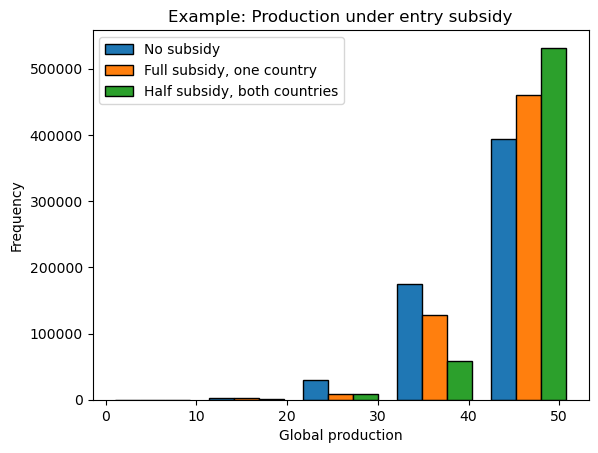

In [43]:
# Create a stacked histogram
plt.hist([no_subsidy, full_subsidy, half_subsidy], bins=5, label=['No subsidy', 'Full subsidy, one country', 'Half subsidy, both countries'], stacked=False, edgecolor='black')

# Add labels and title
plt.xlabel('Global production')
plt.ylabel('Frequency')
plt.title('Example: Production under entry subsidy')

# Add a legend to distinguish the series
plt.legend()

# Show the plot
plt.show()